In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import psutil
import os
import time
import tracemalloc
import psutil
import sys
from pympler import asizeof
import matplotlib.pyplot as plt
from river import imblearn
from scipy.stats import ttest_rel
import itertools

from river import compose, preprocessing, metrics, stream, linear_model, evaluate
from HybridALMASWA import HybridALMASWANeuralNetworkClassifier
import tensorflow as tf

from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from Hamming import HammingLoss
import seaborn as sns
from tqdm import tqdm 

In [2]:
data = pd.read_csv("/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv")
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,192.168.100.3,80,192.168.100.150,31740,6,7.0,44,1,40,1,...,29200,0,0,0,0,0,0,0,0,Benign
1,192.168.100.150,4463,192.168.100.3,1933,6,0.0,40,1,40,1,...,512,0,0,0,0,0,0,0,0,Benign
2,192.168.100.7,80,192.168.100.149,4853,6,7.0,44,1,180,2,...,5840,512,0,0,0,0,0,0,0,Benign
3,192.168.100.149,57004,192.168.100.3,39723,17,0.0,28,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign
4,192.168.100.150,3121,192.168.100.3,591,6,0.0,40,1,40,1,...,512,0,0,0,0,0,0,0,0,Benign


In [3]:
data.shape

(151054, 45)

In [4]:
print('Original dataset shape  %s' % Counter(data['Attack']))

Original dataset shape  Counter({'DDoS': 73327, 'DoS': 66693, 'Reconnaissance': 10484, 'Benign': 540, 'Theft': 10})


## Experiment 1: Comparing ALMA with HybridALMASWA

### Performance of ALMA

In [5]:
import pandas as pd
from sklearn.utils import shuffle

# Load entire dataset
data = pd.read_csv("/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv")

# Split into features and target
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle the sampled data
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")
    print(f"ROCAUC: {metric['ROCAUC'].get():.4f}")

--- ALMAClassifier ---
Accuracy: 0.7073
Recall: 0.7075
ROCAUC: 0.6843


### Performance of HybridALMASWA

In [6]:
# Load entire dataset
data = pd.read_csv("/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv")

# Split into features and target
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle the sampled data
X, y = shuffle(X, y, random_state=42)


# Define classifiers with their respective pipelines
classifiers = {
    'HybridALMASWAClassifier': compose.Pipeline(
        (
        preprocessing.StandardScaler() |
        HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
            )
        )
    )
}

metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")
    print(f"ROCAUC: {metric['ROCAUC'].get():.4f}")

2025-02-05 09:40:51.336104: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-05 09:40:51.336129: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-05 09:40:51.336135: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-05 09:40:51.336161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-05 09:40:51.336364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


--- HybridALMASWAClassifier ---
Accuracy: 0.9949
Recall: 0.9956
ROCAUC: 0.8932


## Experiment 2 — Model Efficiency & Resource Utilization

In [7]:
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
df = pd.read_csv(DATA_PATH)
df = shuffle(df, random_state=42)

X_cols = [c for c in df.columns if c not in ['IPV4_SRC_ADDR','IPV4_DST_ADDR','Attack','Label']]
X = df[X_cols]
y = df['Label']

df = X.copy()
df['Label'] = y

NUM_CHUNKS = 10
chunks = np.array_split(df, NUM_CHUNKS)

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
    )
)

accuracy = metrics.Accuracy()

time_per_chunk = []
memory_per_chunk = []

for i, chunk in enumerate(chunks, start=1):
    chunk_y = chunk['Label']
    chunk_X = chunk.drop('Label', axis=1)

    start_time = time.perf_counter()
    process = psutil.Process()

    for x_dict, true_label in stream.iter_pandas(chunk_X, chunk_y):
        y_pred = model.predict_one(x_dict)
        model.learn_one(x_dict, true_label)
        accuracy.update(true_label, y_pred)

    end_time = time.perf_counter()
    elapsed_sec = end_time - start_time
    rss_mb = process.memory_info().rss / (1024*1024)

    time_per_chunk.append(elapsed_sec)
    memory_per_chunk.append(rss_mb)

    print(f"Chunk {i}: Time = {elapsed_sec:.2f}s, RSS Memory = {rss_mb:.2f}MB, Accuracy so far = {accuracy.get():.4f}")

print("\n=== Final Efficiency Results ===")
print(f"Final Accuracy: {accuracy.get():.4f}")
print(f"Avg Time/Chunk: {np.mean(time_per_chunk):.2f}s")
print(f"Avg Memory/Chunk: {np.mean(memory_per_chunk):.2f}MB")

/Users/promisea/miniconda3/envs/env_tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Chunk 1: Time = 317.60s, RSS Memory = 89.83MB, Accuracy so far = 0.9860
Chunk 2: Time = 343.30s, RSS Memory = 90.17MB, Accuracy so far = 0.9900
Chunk 3: Time = 334.55s, RSS Memory = 88.41MB, Accuracy so far = 0.9911
Chunk 4: Time = 333.39s, RSS Memory = 89.31MB, Accuracy so far = 0.9920
Chunk 5: Time = 331.75s, RSS Memory = 88.50MB, Accuracy so far = 0.9923
Chunk 6: Time = 339.93s, RSS Memory = 89.39MB, Accuracy so far = 0.9927
Chunk 7: Time = 318.12s, RSS Memory = 88.66MB, Accuracy so far = 0.9934
Chunk 8: Time = 154.57s, RSS Memory = 91.58MB, Accuracy so far = 0.9939
Chunk 9: Time = 290.74s, RSS Memory = 90.23MB, Accuracy so far = 0.9944
Chunk 10: Time = 260.16s, RSS Memory = 89.33MB, Accuracy so far = 0.9948

=== Final Efficiency Results ===
Final Accuracy: 0.9948
Avg Time/Chunk: 302.41s
Avg Memory/Chunk: 89.54MB


## Experiment 3 — Scalability with Increasing Data

In [8]:
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
df = pd.read_csv(DATA_PATH)
df = shuffle(df, random_state=42)

X = df.drop(['IPV4_SRC_ADDR','IPV4_DST_ADDR','Attack','Label'], axis=1)
y = df['Label']

df_merged = X.copy()
df_merged['Label'] = y

fractions = [0.1, 0.25, 0.5, 1.0]
results = []

for frac in fractions:
    # Sample the data fraction
    df_sample = df_merged.sample(frac=frac, random_state=42)
    X_sample = df_sample.drop('Label', axis=1)
    y_sample = df_sample['Label']

    # Build fresh pipeline
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
        )
    )
    accuracy = metrics.Accuracy()

    start_time = time.perf_counter()

    # Prequential training
    for x_dict, true_label in stream.iter_pandas(X_sample, y_sample):
        y_pred = model.predict_one(x_dict)
        model.learn_one(x_dict, true_label)
        accuracy.update(true_label, y_pred)

    end_time = time.perf_counter()
    elapsed_sec = end_time - start_time
    results.append({
        'fraction': frac,
        'accuracy': accuracy.get(),
        'time_secs': elapsed_sec,
        'num_samples': len(df_sample)
    })

print("=== Experiment 7: Scalability ===")
for r in results:
    print(f"Fraction={r['fraction']}, #Samples={r['num_samples']}, Accuracy={r['accuracy']:.4f}, Time={r['time_secs']:.2f}s")


=== Experiment 7: Scalability ===
Fraction=0.1, #Samples=15105, Accuracy=0.9893, Time=292.76s
Fraction=0.25, #Samples=37764, Accuracy=0.9934, Time=810.19s
Fraction=0.5, #Samples=75527, Accuracy=0.9943, Time=975.65s
Fraction=1.0, #Samples=151054, Accuracy=0.9952, Time=2728.34s


## Experiment 4: Measuring TPR AND FPR

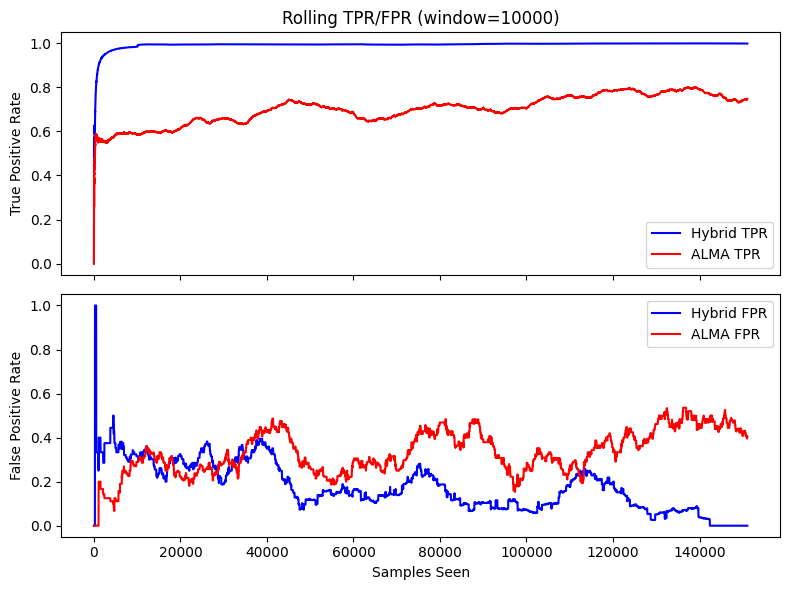


=== Final Results ===
Hybrid Accuracy: 0.9951
ALMA Accuracy: 0.7073


In [15]:
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
data = pd.read_csv(DATA_PATH)

# Separate features from label
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle
X, y = shuffle(X, y, random_state=42)

# ----------------------------------------------------------------------
# 3) Define a helper for computing TPR/FPR in a rolling window
# ----------------------------------------------------------------------
def compute_tpr_fpr(pairs):
    """
    pairs is a list of (true_label, predicted_label), both in {True, False}.
    Returns (TPR, FPR).
    """
    tp = sum(1 for (t, p) in pairs if t and p)
    tn = sum(1 for (t, p) in pairs if not t and not p)
    fp = sum(1 for (t, p) in pairs if not t and p)
    fn = sum(1 for (t, p) in pairs if t and not p)

    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    return tpr, fpr

# ----------------------------------------------------------------------
# 4) Create two pipelines: Hybrid and ALMA
# ----------------------------------------------------------------------

models = {
    'Hybrid': compose.Pipeline(
        preprocessing.StandardScaler(),
        HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8)
    ),
    'ALMA': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    )
}

# ----------------------------------------------------------------------
# 5) Rolling TPR/FPR tracking with a chosen window size
# ----------------------------------------------------------------------
window_size = 10000

# Deques to store (true_label, pred_label) for the last N predictions
from collections import deque

ring_buffers = {
    'Hybrid': deque(maxlen=window_size),
    'ALMA': deque(maxlen=window_size)
}

# We'll store TPR/FPR at each step for plotting
tpr_history = {'Hybrid': [], 'ALMA': []}
fpr_history = {'Hybrid': [], 'ALMA': []}

# (Optional) overall accuracy trackers
accuracy = {'Hybrid': metrics.Accuracy(), 'ALMA': metrics.Accuracy()}

# ----------------------------------------------------------------------
# 6) Prequential streaming & metric calculation
# ----------------------------------------------------------------------
# If your labels are NOT booleans, map them to True/False here. For example:
# We'll assume 'y' is already boolean. If not, do something like:
# y = (y == 'Attack') or similar.

for x_dict, true_label in stream.iter_pandas(X, y):
    # Convert to boolean if necessary
    # e.g. if true_label in {0,1} we can do: true_label = bool(true_label)

    for name, model in models.items():
        # Predict and learn
        y_pred = model.predict_one(x_dict)
        model.learn_one(x_dict, true_label)

        # Update overall accuracy
        accuracy[name].update(true_label, y_pred)

        # Add to rolling buffer
        ring_buffers[name].append((true_label, y_pred))

        # Compute TPR/FPR for the last 'window_size' samples
        tpr, fpr = compute_tpr_fpr(ring_buffers[name])
        tpr_history[name].append(tpr)
        fpr_history[name].append(fpr)


# ----------------------------------------------------------------------
# 7) Plotting
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
t_axis = np.arange(len(tpr_history['Hybrid']))

# Plot TPR
axes[0].plot(t_axis, tpr_history['Hybrid'], label='Hybrid TPR', color='blue')
axes[0].plot(t_axis, tpr_history['ALMA'],   label='ALMA TPR',   color='red')
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc='best')
axes[0].set_title(f"Rolling TPR/FPR (window={window_size})")

# Plot FPR
axes[1].plot(t_axis, fpr_history['Hybrid'], label='Hybrid FPR', color='blue')
axes[1].plot(t_axis, fpr_history['ALMA'],   label='ALMA FPR',   color='red')
axes[1].set_ylabel("False Positive Rate")
axes[1].set_xlabel("Samples Seen")
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig('Hybrid_BoT_TPR.png')
plt.show()

# ----------------------------------------------------------------------
# 8) Print final Accuracy
# ----------------------------------------------------------------------
print("\n=== Final Results ===")
for name in models:
    print(f"{name} Accuracy: {accuracy[name].get():.4f}")

## Experimemt 5: Measuring Latency and Throughout 

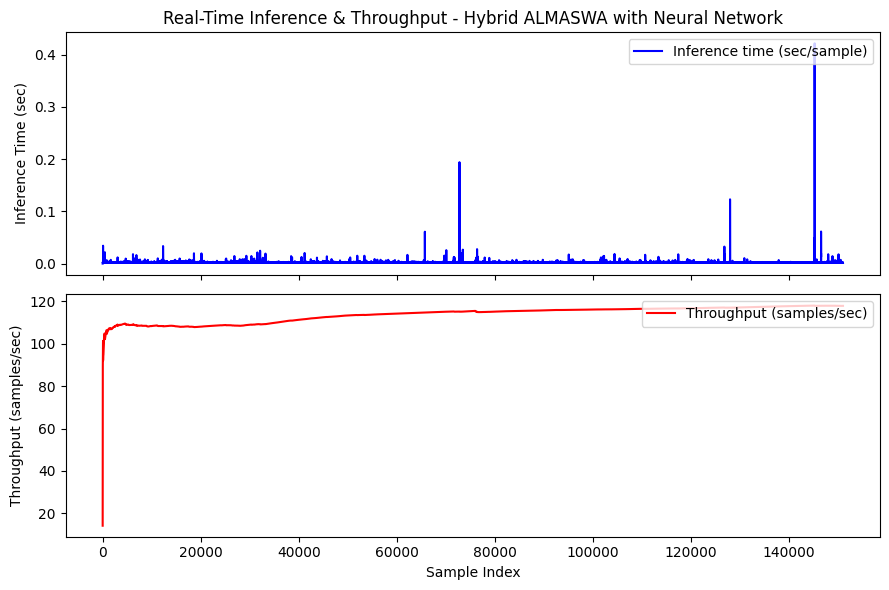

In [16]:
import time
import collections
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from river import compose, preprocessing, stream

# ---------------------------------------------------------------------
# 1) Load & Shuffle the Dataset
# ---------------------------------------------------------------------
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
data = pd.read_csv(DATA_PATH)

X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

X, y = shuffle(X, y, random_state=42)


# ---------------------------------------------------------------------
# 3) Build Pipeline & Prepare for Measurements
# ---------------------------------------------------------------------
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
    )
)

# We'll track:
#  - Inference time (seconds) per sample
#  - Throughput (samples/sec) in real-time

inference_times = []
throughputs = []
start_time = time.perf_counter()
sample_count = 0

# ---------------------------------------------------------------------
# 4) Stream & Measure Real-time Inference + Throughput
# ---------------------------------------------------------------------
for x_dict, true_label in stream.iter_pandas(X, y):
    # If 'Label' isn't boolean, map it here: 
    #   true_label = (true_label == "Attack") or something similar

    # Measure inference time
    t0 = time.perf_counter()
    y_pred = model.predict_one(x_dict)
    inference_time = time.perf_counter() - t0

    # Learn
    model.learn_one(x_dict, true_label)

    # Store inference time
    inference_times.append(inference_time)

    # Update throughput (samples / total_time)
    sample_count += 1
    elapsed_time = time.perf_counter() - start_time
    throughput = sample_count / elapsed_time if elapsed_time > 0 else 0
    throughputs.append(throughput)

# ---------------------------------------------------------------------
# 5) Plot Real-Time Inference & Throughput
# ---------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), sharex=True)

axes[0].plot(inference_times, label='Inference time (sec/sample)', color='blue')
axes[0].set_ylabel('Inference Time (sec)')
axes[0].legend(loc='upper right')
axes[0].set_title('Real-Time Inference & Throughput - Hybrid ALMASWA with Neural Network')

axes[1].plot(throughputs, label='Throughput (samples/sec)', color='red')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Throughput (samples/sec)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Hybrid_BoT_Throughput.png')
plt.show()

## Experiment 6: Evaluating the adversarial robustness

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from river import stream, compose, preprocessing, metrics
import tensorflow as tf
import time
import collections
import math
from river import base, utils

# ---------------------------------------------------------------------
# 1) Load & Shuffle the Dataset
# ---------------------------------------------------------------------
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
data = pd.read_csv(DATA_PATH)

# Separate features and label
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle
X, y = shuffle(X, y, random_state=42)

# If your labels are strings (e.g. "Attack"/"Benign"), convert them to booleans here:
# y = (y == "Attack")



# ---------------------------------------------------------------------
# 3) A Simple FGSM-like Adversarial Attack Function (Corrected)
# ---------------------------------------------------------------------
def generate_adversarial_example(x_dict, model, epsilon=0.01, target_attack=True):
    """
    A naive FGSM approach that tries to reduce the model's predicted
    probability of 'True' (evasion) or increase it.

    Args:
      x_dict (dict): original input features
      model (HybridALMASWANeuralNetworkClassifier): your trained or updated model
      epsilon (float): magnitude of the perturbation
      target_attack (bool): if True, reduce prob of 'True'; if False, increase.

    Returns:
      dict: adversarially perturbed features
    """
    # If the TF model isn't built yet, we can't do gradient-based adversaries
    if not model.model_built:
        return x_dict

    # Convert x_dict -> TF tensor
    original_tensor = model._dict_to_tensor(x_dict)

    with tf.GradientTape() as tape:
        # watch the input tensor for gradients
        tape.watch(original_tensor)
        # forward pass
        pred = model.model(original_tensor, training=False)  # shape (1,1)

        # define the "loss" we want to minimize or maximize
        # if we want to reduce the prob of 'True' => loss = pred
        # if we want to increase the prob => loss = 1 - pred
        loss = pred if target_attack else (1 - pred)

    # compute the gradient of the loss w.r.t. the input
    grad = tape.gradient(loss, original_tensor)  # shape (1, n_features)
    signed_grad = tf.sign(grad)

    # FGSM update: push input in direction that reduces pred(attack=True)
    if target_attack:
        X_adv = original_tensor - epsilon * signed_grad
    else:
        X_adv = original_tensor + epsilon * signed_grad

    # Convert tensor back to dict
    x_adv_dict = {}
    for i, feat in enumerate(model.feature_order):
        x_adv_dict[feat] = float(X_adv[0, i].numpy())

    return x_adv_dict


# ---------------------------------------------------------------------
# 4) Streaming Adversarial Robustness Evaluation
# ---------------------------------------------------------------------
pipeline = compose.Pipeline(
    preprocessing.StandardScaler(),
    HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
    )
)

# We'll track:
acc_clean = metrics.Accuracy()  # accuracy on original data
acc_adv   = metrics.Accuracy()  # accuracy on adversarial data

n_samples = 0
n_successful_attacks = 0  # # times an original True -> adv False
epsilon = 0.1            # adversarial perturbation magnitude

for x_dict, true_label in stream.iter_pandas(X, y):
    # (Optionally) convert label to bool if not already:
    # true_label = bool(true_label)

    # 1) Predict on clean data
    y_pred_clean = pipeline.predict_one(x_dict)

    # 2) Learn (prequential)
    pipeline.learn_one(x_dict, true_label)

    # 3) Update metrics for clean sample
    acc_clean.update(true_label, y_pred_clean)

    # 4) Craft adversarial example that tries to reduce 'True' probability
    x_adv = generate_adversarial_example(
        x_dict,
        pipeline['HybridALMASWANeuralNetworkClassifier'],
        epsilon=epsilon,
        target_attack=True
    )

    # 5) Predict on the adversarial sample
    y_pred_adv = pipeline.predict_one(x_adv)
    acc_adv.update(true_label, y_pred_adv)

    # 6) Check if we flipped from True to False => successful evasion
    if (y_pred_clean == True) and (y_pred_adv == False):
        n_successful_attacks += 1

    n_samples += 1

# ---------------------------------------------------------------------
# 5) Print Results
# ---------------------------------------------------------------------
print("\n=== Adversarial Robustness Evaluation ===")
print(f"Total samples processed: {n_samples}")
print(f"Adversarial epsilon: {epsilon}")
print(f"Clean Accuracy: {acc_clean.get():.4f}")
print(f"Adversarial Accuracy: {acc_adv.get():.4f}")

flip_rate = n_successful_attacks / n_samples if n_samples > 0 else 0
print(f"Rate of successful flips (True->False): {flip_rate:.4%}")


=== Adversarial Robustness Evaluation ===
Total samples processed: 151054
Adversarial epsilon: 0.1
Clean Accuracy: 0.9951
Adversarial Accuracy: 0.9954
Rate of successful flips (True->False): 0.0053%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from river import stream, compose, preprocessing, metrics
import tensorflow as tf
import time
import collections
import math
from river import base, utils

# ---------------------------------------------------------------------
# 1) Load & Shuffle the Dataset
# ---------------------------------------------------------------------
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
data = pd.read_csv(DATA_PATH)

# Separate features and label
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle
X, y = shuffle(X, y, random_state=42)

# If your labels are strings (e.g. "Attack"/"Benign"), convert them to booleans here:
# y = (y == "Attack")



# ---------------------------------------------------------------------
# 3) A Simple FGSM-like Adversarial Attack Function (Corrected)
# ---------------------------------------------------------------------
def generate_adversarial_example(x_dict, model, epsilon=0.01, target_attack=True):
    """
    A naive FGSM approach that tries to reduce the model's predicted
    probability of 'True' (evasion) or increase it.

    Args:
      x_dict (dict): original input features
      model (HybridALMASWANeuralNetworkClassifier): your trained or updated model
      epsilon (float): magnitude of the perturbation
      target_attack (bool): if True, reduce prob of 'True'; if False, increase.

    Returns:
      dict: adversarially perturbed features
    """
    # If the TF model isn't built yet, we can't do gradient-based adversaries
    if not model.model_built:
        return x_dict

    # Convert x_dict -> TF tensor
    original_tensor = model._dict_to_tensor(x_dict)

    with tf.GradientTape() as tape:
        # watch the input tensor for gradients
        tape.watch(original_tensor)
        # forward pass
        pred = model.model(original_tensor, training=False)  # shape (1,1)

        # define the "loss" we want to minimize or maximize
        # if we want to reduce the prob of 'True' => loss = pred
        # if we want to increase the prob => loss = 1 - pred
        loss = pred if target_attack else (1 - pred)

    # compute the gradient of the loss w.r.t. the input
    grad = tape.gradient(loss, original_tensor)  # shape (1, n_features)
    signed_grad = tf.sign(grad)

    # FGSM update: push input in direction that reduces pred(attack=True)
    if target_attack:
        X_adv = original_tensor - epsilon * signed_grad
    else:
        X_adv = original_tensor + epsilon * signed_grad

    # Convert tensor back to dict
    x_adv_dict = {}
    for i, feat in enumerate(model.feature_order):
        x_adv_dict[feat] = float(X_adv[0, i].numpy())

    return x_adv_dict


# ---------------------------------------------------------------------
# 4) Streaming Adversarial Robustness Evaluation
# ---------------------------------------------------------------------
pipeline = compose.Pipeline(
    preprocessing.StandardScaler(),
    HybridALMASWANeuralNetworkClassifier(
        alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8
    )
)

# We'll track:
acc_clean = metrics.Accuracy()  # accuracy on original data
acc_adv   = metrics.Accuracy()  # accuracy on adversarial data

n_samples = 0
n_successful_attacks = 0  # # times an original True -> adv False
epsilon = 0.2            # adversarial perturbation magnitude

for x_dict, true_label in stream.iter_pandas(X, y):
    # (Optionally) convert label to bool if not already:
    # true_label = bool(true_label)

    # 1) Predict on clean data
    y_pred_clean = pipeline.predict_one(x_dict)

    # 2) Learn (prequential)
    pipeline.learn_one(x_dict, true_label)

    # 3) Update metrics for clean sample
    acc_clean.update(true_label, y_pred_clean)

    # 4) Craft adversarial example that tries to reduce 'True' probability
    x_adv = generate_adversarial_example(
        x_dict,
        pipeline['HybridALMASWANeuralNetworkClassifier'],
        epsilon=epsilon,
        target_attack=True
    )

    # 5) Predict on the adversarial sample
    y_pred_adv = pipeline.predict_one(x_adv)
    acc_adv.update(true_label, y_pred_adv)

    # 6) Check if we flipped from True to False => successful evasion
    if (y_pred_clean == True) and (y_pred_adv == False):
        n_successful_attacks += 1

    n_samples += 1

# ---------------------------------------------------------------------
# 5) Print Results
# ---------------------------------------------------------------------
print("\n=== Adversarial Robustness Evaluation ===")
print(f"Total samples processed: {n_samples}")
print(f"Adversarial epsilon: {epsilon}")
print(f"Clean Accuracy: {acc_clean.get():.4f}")
print(f"Adversarial Accuracy: {acc_adv.get():.4f}")

flip_rate = n_successful_attacks / n_samples if n_samples > 0 else 0
print(f"Rate of successful flips (True->False): {flip_rate:.4%}")


=== Adversarial Robustness Evaluation ===
Total samples processed: 151054
Adversarial epsilon: 0.2
Clean Accuracy: 0.9949
Adversarial Accuracy: 0.9953
Rate of successful flips (True->False): 0.0066%


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from river import stream, compose, preprocessing, metrics
import tensorflow as tf
import time
import collections
import math
from river import base, utils

# ---------------------------------------------------------------------
# 1) Load & Shuffle the Dataset
# ---------------------------------------------------------------------
DATA_PATH = "/Users/promisea/Datasets/NF Datasets/BoT IoT/NF-BoT-IoT-Sample.csv"
data = pd.read_csv(DATA_PATH)

# Separate features and label
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']

# Shuffle
X, y = shuffle(X, y, random_state=42)

# If your labels are strings (e.g. "Attack"/"Benign"), convert them to booleans here:
# y = (y == "Attack")



# ---------------------------------------------------------------------
# 3) A Simple FGSM-like Adversarial Attack Function (Corrected)
# ---------------------------------------------------------------------
def generate_adversarial_example(x_dict, model, epsilon=0.01, target_attack=True):
    """
    A naive FGSM approach that tries to reduce the model's predicted
    probability of 'True' (evasion) or increase it.

    Args:
      x_dict (dict): original input features
      model (HybridALMASWANeuralNetworkClassifier): your trained or updated model
      epsilon (float): magnitude of the perturbation
      target_attack (bool): if True, reduce prob of 'True'; if False, increase.

    Returns:
      dict: adversarially perturbed features
    """
    # If the TF model isn't built yet, we can't do gradient-based adversaries
    if not model.model_built:
        return x_dict

    # Convert x_dict -> TF tensor
    original_tensor = model._dict_to_tensor(x_dict)

    with tf.GradientTape() as tape:
        # watch the input tensor for gradients
        tape.watch(original_tensor)
        # forward pass
        pred = model.model(original_tensor, training=False)  # shape (1,1)

        # define the "loss" we want to minimize or maximize
        # if we want to reduce the prob of 'True' => loss = pred
        # if we want to increase the prob => loss = 1 - pred
        loss = pred if target_attack else (1 - pred)

    # compute the gradient of the loss w.r.t. the input
    grad = tape.gradient(loss, original_tensor)  # shape (1, n_features)
    signed_grad = tf.sign(grad)

    # FGSM update: push input in direction that reduces pred(attack=True)
    if target_attack:
        X_adv = original_tensor - epsilon * signed_grad
    else:
        X_adv = original_tensor + epsilon * signed_grad

    # Convert tensor back to dict
    x_adv_dict = {}
    for i, feat in enumerate(model.feature_order):
        x_adv_dict[feat] = float(X_adv[0, i].numpy())

    return x_adv_dict


# ---------------------------------------------------------------------
# 4) Streaming Adversarial Robustness Evaluation
# ---------------------------------------------------------------------
pipeline = compose.Pipeline(
    preprocessing.StandardScaler(),
    HybridALMASWANeuralNetworkClassifier(alma_swa_start=50,
        alma_swa_freq=10,
        hidden_units=8,
        learning_rate=0.01,
        ensemble_weight=0.8)
)

# We'll track:
acc_clean = metrics.Accuracy()  # accuracy on original data
acc_adv   = metrics.Accuracy()  # accuracy on adversarial data

n_samples = 0
n_successful_attacks = 0  # # times an original True -> adv False
epsilon = 0.3            # adversarial perturbation magnitude

for x_dict, true_label in stream.iter_pandas(X, y):
    # (Optionally) convert label to bool if not already:
    # true_label = bool(true_label)

    # 1) Predict on clean data
    y_pred_clean = pipeline.predict_one(x_dict)

    # 2) Learn (prequential)
    pipeline.learn_one(x_dict, true_label)

    # 3) Update metrics for clean sample
    acc_clean.update(true_label, y_pred_clean)

    # 4) Craft adversarial example that tries to reduce 'True' probability
    x_adv = generate_adversarial_example(
        x_dict,
        pipeline['HybridALMASWANeuralNetworkClassifier'],
        epsilon=epsilon,
        target_attack=True
    )

    # 5) Predict on the adversarial sample
    y_pred_adv = pipeline.predict_one(x_adv)
    acc_adv.update(true_label, y_pred_adv)

    # 6) Check if we flipped from True to False => successful evasion
    if (y_pred_clean == True) and (y_pred_adv == False):
        n_successful_attacks += 1

    n_samples += 1

# ---------------------------------------------------------------------
# 5) Print Results
# ---------------------------------------------------------------------
print("\n=== Adversarial Robustness Evaluation ===")
print(f"Total samples processed: {n_samples}")
print(f"Adversarial epsilon: {epsilon}")
print(f"Clean Accuracy: {acc_clean.get():.4f}")
print(f"Adversarial Accuracy: {acc_adv.get():.4f}")

flip_rate = n_successful_attacks / n_samples if n_samples > 0 else 0
print(f"Rate of successful flips (True->False): {flip_rate:.4%}")


=== Adversarial Robustness Evaluation ===
Total samples processed: 151054
Adversarial epsilon: 0.3
Clean Accuracy: 0.9950
Adversarial Accuracy: 0.9954
Rate of successful flips (True->False): 0.0053%
